# CIS 5800 Machine Perception 24 Spring
# Homework 1 - Coding Part

## Instructions
- This is the coding part for homework 1 and worth 44 points.
- Start early! Please post your questions on Ed Discussion (using the appropriate thread category) or come to office hours!

## Submission
- You need to make a copy of this notebook and fill in all the sections where `##### STUDENT CODE START #####` is indicated.
- Download `.ipynb` and `.py` file of this notebook and rename as `homework1.ipynb` and `homework1.py`, and submit these two files to Gradescope.




# 0. Introduction
In this programming assignment, we will use the concepts of projective geometry and homographies to allow us to project an image onto a scene in a natural way that respects perspective. To demonstrate this, we will project our logo onto the goal during a football match. For this assignment, we have provided images from a video sequence of a football match, as well as the corners of the goal in each image and an image of the Penn Engineering logo. Your task is, for each image in the video sequence, compute the homography between the Penn logo and the goal, and then warp the goal points onto the ones in the Penn logo to generate a projection of the logo onto the video frame.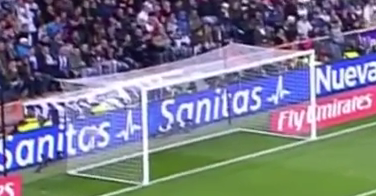 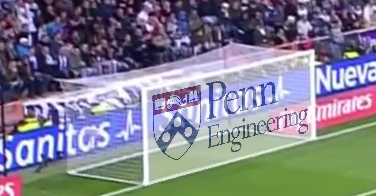


In [ ]:
import os
import sys

# For autograder only, do not modify this cell.
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


# 1. Introduction to Numpy

This part is meant to introduce some basic matrix manipulations with Numpy. You do not need to do anything in this part. You can run these cells to see the usage of different functions.

In [ ]:
import numpy as np

# Create matrix
mat1 = np.array([[1., 2., 3.], [4., 5., 6.]])
print("mat1 : \n", mat1)
mat2 = np.ones((2, 3))
print("mat2 : \n", mat1)
mat3 = np.eye(3)
print("mat3 : \n", mat3)

mat1 : 
 [[1. 2. 3.]
 [4. 5. 6.]]
mat2 : 
 [[1. 2. 3.]
 [4. 5. 6.]]
mat3 : 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
# matrix index
print(f"Element at (1, 2) in mat1 is: {mat1[1, 2]}")
# Use : to select all elements.
# Use ::step to select elements with stride=step
print(f"Even colums are \n {mat1[:, ::2]}")
# You can also use ::-1 or np.flip to flip the matrix
print(f" Flip matrix \n {mat1[:, ::-1]} ")
# Use binary mask to index
mask = np.array([[True, False, False], [False, True, False]])
print(f" Index \n {mat1[mask]}")
# Use None to expand dims
print(f" Expand {np.arange(3)} vector to 1x3 matrix {np.arange(3)[None, :]}")

Element at (1, 2) in mat1 is: 6.0
Even colums are 
 [[1. 3.]
 [4. 6.]]
 Flip matrix 
 [[3. 2. 1.]
 [6. 5. 4.]] 
 Index 
 [1. 5.]
 Expand [0 1 2] vector to 1x3 matrix [[0 1 2]]


In [ ]:
# Matrix manipulation
# Matrix transpose
print(f"The transpose of mat1: \n {mat1.T}")
# Matrix reshape
print(f"Reshape mat1 to 3x2: \n {mat1.reshape(3, 2)}")
# Matrix multiplication
print(f" mat1.T x mat1 = \n {mat1.T @ mat1} ")
# element-wise matrix multiplication
print(f" mat1 * mat1 = \n {mat1 * mat1} ")
# concatenation
print(f" concatenate two mat1 matrix \n {np.concatenate([mat1, mat1], axis=0)}")

The transpose of mat1: 
 [[1. 4.]
 [2. 5.]
 [3. 6.]]
Reshape mat1 to 3x2: 
 [[1. 2.]
 [3. 4.]
 [5. 6.]]
 mat1.T x mat1 = 
 [[17. 22. 27.]
 [22. 29. 36.]
 [27. 36. 45.]] 
 mat1 * mat1 = 
 [[ 1.  4.  9.]
 [16. 25. 36.]] 
 concatenate two mat1 matrix 
 [[1. 2. 3.]
 [4. 5. 6.]
 [1. 2. 3.]
 [4. 5. 6.]]


# 2 Homography Estimation
To project one image patch onto another, we need, for each point inside the goal in the video frame, to find the corresponding point from the logo image to copy over. In other words, we need to calculate the homography between the two image patches. This homography is a 3x3 matrix that satisfies the following:

$$ x_{logo} \sim H x_{video} $$

Or, equivalently:

$$ \lambda x_{logo} = H x_{video} $$

Where $x_{logo}$ and $x_{video}$ are homogeneous image coordinates from each patch and λ is some scaling constant. To calculate the homography needed for this projection, we provide, for each image, the corners of the patches that we would like you to warp between in each image. You must calculate the homography using the provided corner points and the technique covered in the lectures and Appendix (https://drive.google.com/file/d/1UvIM1kOHi9epE90a3qh0PV6_Bq95IeXG/view?usp=sharing). You can then warp each image point using H to find its corresponding point in the logo (note that the homography equation is estimated up to a scalar, so you will need to divide $H x_{image}$ by the third term, which is $\lambda$), and then return the set of corresponding points as a matrix.


In [ ]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def est_homography(X, Y):
    """
    Calculates the homography of two planes, from the plane defined by X
    to the plane defined by Y. In this assignment, X are the coordinates of the
    four corners of the soccer goal while Y are the four corners of the penn logo

    Input:
        X: 4x2 matrix of (x,y) coordinates of goal corners in video frame
        Y: 4x2 matrix of (x,y) coordinates of logo corners in penn logo
    Returns:
        H: 3x3 homogeneours transformation matrix s.t. Y ~ H*X

    CAUTION: you should keep the shape of input and output arrays, or you may fail the test
    """
    ##### STUDENT CODE START #####

    num_points = X.shape[0]
    A = np.zeros((2*num_points, 9))

    for i in range(num_points):
        x, y = X[i, 0], X[i, 1]
        u, v = Y[i, 0], Y[i, 1]
        A[2*i] = [-x, -y, -1, 0, 0, 0, u*x, u*y, u]
        A[2*i+1] = [0, 0, 0, -x, -y, -1, v*x, v*y, v]

    # Use SVD to solve Ah = 0
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1]  # The last row of V^T (or the last column of V) is the solution

    # Reshape h into the 3x3 homography matrix
    H = h.reshape(3, 3)

    ##### STUDENT CODE END #####
    return H

Here we provide the skeleton code for you to test your function.


In [ ]:
##### STUDENT CODE #####
# you can write any code here to test your function
X = np.array([[0, 0],[0, 10], [5, 0], [5, 10]])
Y = np.array([[3, 4], [4, 11],[8, 5], [9, 12]] )
H = est_homography(X, Y)

# 3. Warp Points

You may be wondering why we are calculating the projection from the video frames to the logo image, when we want to project the logo image onto the video frames. We do this because, if we compute the inverse homography, and project all the logo points into the video frame, we will most likely have the case where multiple logo points are projected to one video frame pixel (due to rounding of the pixels), while other pixels may have no logo points at all. This results in 'holes' in the video frame where no logo points are mapped. To avoid this, we calculate the projection from video frame points to logo points to guarantee that every video frame gets a point from the logo.

We can then replace every point in the video frame ($\mathbf{x}_{video}$) with the corresponding point in the logo ($\mathbf{x}_{logo}$) using the correspondences $(\mathbf{x}_{image}, \mathbf{x}_{logo})$. This is already done for you in **inverse$\_$warping**, and you should not need to change it.


In [ ]:

def warp_pts(X, Y, interior_pts):
    """
    First compute homography from video_pts to logo_pts using X and Y,
    and then use this homography to warp all points inside the soccer goal

    Input:
        X: 4x2 matrix of (x,y) coordinates of goal corners in video frame
        Y: 4x2 matrix of (x,y) coordinates of logo corners in penn logo
        interior_pts: Nx2 matrix of points inside goal
    Returns:
        warped_pts: Nx2 matrix containing new coordinates for interior_pts.
        These coordinate describe where a point inside the goal will be warped
        to inside the penn logo. For this assignment, you can keep these new
        coordinates as float numbers.

    """

    # You should Complete est_homography first!
    H = est_homography(X, Y)

    # Convert interior points to homogeneous coordinates
    ones = np.ones((interior_pts.shape[0], 1))
    homogeneous_pts = np.hstack((interior_pts, ones))

    # Apply the homography to the points
    warped_homogeneous_pts = np.dot(H, homogeneous_pts.T).T

    # Normalize to convert back to Cartesian coordinates
    warped_pts = warped_homogeneous_pts[:, :2] / warped_homogeneous_pts[:, 2, np.newaxis]

    ##### STUDENT CODE START #####


    ##### STUDENT CODE END #####
    return warped_pts

# 4. Utils and Libs
Define necessary utils and libs. You don't need to modify anything here.

In [ ]:
"""
utils functions for part 1 (Barcelona)
STUDENTS SHOULDN'T NEED TO CHANGE THIS

"""

import numpy as np
from matplotlib.path import Path


def calculate_interior_pts(image_size, corners):
    """
    Calculate_interior_pts takes in the size of an image and a set of corners
    that define a polygon in the image, and returns all (x,y) points within
    the polygon

    Input:
        image_size: size of image in [y,x]
        corners: the four corners of a polygon in [x,y] format
    Returns:
        interior_pts: coordinates of points inside polygon in [x,y] format

    """

    # YOU DON'T NEED TO CHANGE THIS
    path = Path(corners)

    xx, yy = np.meshgrid(range(image_size[1]), range(image_size[0]))
    xxyy = np.stack([xx.ravel(), yy.ravel()], 1)

    interior_ind = path.contains_points(xxyy)
    interior_pts = xxyy[interior_ind]

    return interior_pts


def inverse_warping(img_initial, img_final, pts_initial, pts_final):
    """
    takes two images and a set of correspondences between them,
    and warps all the pts_inital in img_initial to the pts_final in img_final

    Input:
        img_initial: initial image on top of which we want to overlay img_final
        img_final:   target image to lay on top of img_initial
        pts_initial: Nx2 matrix of (x,y) coordinates of points in video frame
        pts_final:   Nx2 matrix of (x,y) coordinates of points in penn logo
    Returns:
        projected_img:

    """

    # YOU DON'T NEED TO CHANGE THIS
    pts_final = pts_final.astype(int)
    pts_initial = pts_initial.astype(int)

    projected_img = img_initial.copy()
    for i in range(3):
        sub_img_i = img_initial[:,:,i][pts_initial[:,1], pts_initial[:,0]]
        sub_img_f = img_final[:,:,i][pts_final[:,1], pts_final[:,0]]

        # sub_img = sub_img_i*1 + sub_img_f*1
        sub_img = sub_img_f*1
        projected_img[:,:,i][pts_initial[:,1], pts_initial[:,0]] = sub_img

    return projected_img


# 5. Visualization

We can now combine everything and produce the results. The Penn logo will show if functions are correctly implemented!


In [ ]:
os.system("gdown 1DS0mfEU1G_bNsztXLyf0kYbaUNytFbF0")
os.system("unzip -qq HW1_data.zip")
os.system("pip install -q mediapy")

Downloading...
From (original): https://drive.google.com/uc?id=1DS0mfEU1G_bNsztXLyf0kYbaUNytFbF0
From (redirected): https://drive.google.com/uc?id=1DS0mfEU1G_bNsztXLyf0kYbaUNytFbF0&confirm=t&uuid=eba9eaf3-4c84-4ae9-9c89-c87f1d019323
To: /Users/saikoushik/Documents/CIS 580/hw/HW1/HW1_data.zip
100%|██████████| 119M/119M [00:06<00:00, 18.4MB/s] 


0

(400, 990, 3)


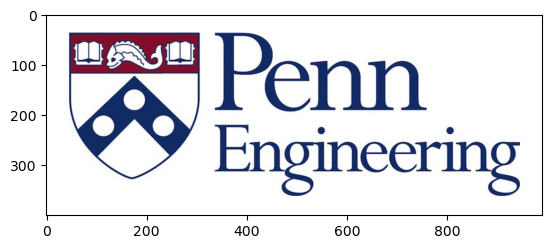

In [ ]:
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

penn = cv2.imread("./data/barcelona/images/logos/penn_engineering_logo.png") # in BGR
if(penn):
  print(penn.shape)
  penn = cv2.cvtColor(penn, cv2.COLOR_BGR2RGB)
  plt.imshow(penn)


In [ ]:
"""
Visualization script for part 1 (Barcelona)

Note: You don't have to change this script for the assignment, but you
can if you'd like to change the images or other parameters

"""

import glob
import numpy as np
import cv2


penn = cv2.imread("./data/barcelona/images/logos/penn_engineering_logo.png")
if(penn):
  penn_y, penn_x, _ = penn.shape
  penn_corners = np.array([[0, 0], [penn_x, 0], [penn_x, penn_y], [0, penn_y]])

  # Load all image paths, and the goal corners in each image
  img_files = sorted(glob.glob("./data/barcelona/images/barca_real/*.png"))
  goal_data = np.load("./data/barcelona/BarcaReal_pts.npy")

  print(goal_data)
  # Process all images
  processed_imgs = []
  for i in range(len(goal_data)):
      goal = cv2.imread(img_files[i])
      goal_corners = goal_data[i]
      # Warping
      int_pts = calculate_interior_pts(goal.shape, goal_corners)
      warped_pts = warp_pts(goal_corners, penn_corners, int_pts)
      projected_img = inverse_warping(goal, penn, int_pts, warped_pts)

      processed_imgs.append(projected_img)

  # Save some examples
  save_ind = [0, 25, 50, 75, 100, 125]
  if not os.path.exists("part_1_results"):
      os.mkdir("part_1_results")

  for ind in save_ind:
      cv2.imwrite("part_1_results/frame_" + str(ind) + ".png", processed_imgs[ind])

  video_path = "result.mp4"
  # Visualize the sequence of projected images
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  out = cv2.VideoWriter(video_path, fourcc, 20, (1280, 720), True)


  for im in processed_imgs:
      out.write(im)
  out.release()

  import mediapy as media
  media.show_video(media.read_video(video_path), height=360)


[[[141.536      175.326     ]
  [293.248      142.6483    ]
  [295.4956     219.9856    ]
  [144.9074     261.3775    ]]

 [[148.98664856 177.89871216]
  [300.52075195 145.35231018]
  [302.52896118 222.38026428]
  [152.36323547 263.8913269 ]]

 [[155.76785278 181.12167358]
  [306.99917603 148.59559631]
  [309.08630371 225.46516418]
  [158.84136963 267.16870117]]

 ...

 [[509.33044434 224.40792847]
  [746.09143066 171.20935059]
  [745.70775623 296.17867036]
  [510.6539917  358.9413147 ]]

 [[514.63800049 223.68348694]
  [752.25219727 170.1293335 ]
  [752.68836565 297.17590028]
  [516.08123779 358.70376587]]

 [[519.42462158 222.89881897]
  [757.96002197 169.00668335]
  [758.67174515 296.17867036]
  [520.53918457 358.33132935]]]


RuntimeError: Unable to find frames in video: ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox --enable-audiotoolbox --enable-neon
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16.100 / 60. 16.100
  libavdevice    60.  3.100 / 60.  3.100
  libavfilter     9. 12.100 /  9. 12.100
  libswscale      7.  5.100 /  7.  5.100
  libswresample   4. 12.100 /  4. 12.100
  libpostproc    57.  3.100 / 57.  3.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'result.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2mp41
    encoder         : Lavf60.3.100
  Duration: 00:00:06.45, start: 0.000000, bitrate: 7969 kb/s
  Stream #0:0[0x1](und): Video: mpeg4 (Simple Profile) (mp4v / 0x7634706D), yuv420p, 1280x720 [SAR 1:1 DAR 16:9], 7967 kb/s, 20 fps, 20 tbr, 10240 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
Output #0, null, to 'pipe:':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2mp41
    encoder         : Lavf60.16.100
  Stream #0:0(und): Video: mpeg4 (Simple Profile) (mp4v / 0x7634706D), yuv420p, 1280x720 [SAR 1:1 DAR 16:9], q=2-31, 7967 kb/s, 20 fps, 20 tbr, 10240 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
Stream mapping:
  Stream #0:0 -> #0:0 (copy)
size=       0kB time=00:00:00.00 bitrate=N/A speed=N/A    
[out#0/null @ 0x12af13a20] video:6273kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
size=N/A time=00:00:06.40 bitrate=N/A speed=6.31e+03x    


# Submission

**All Coding assignments must be submitted through Gradescope.**

 Please download both .ipynb and .py files (click `File` on the top left and select download) and rename them exactly as **homework1.ipynb** and **homework1.py** before submitting both of these files on Gradescope.